## H20 Interview Solution

In [240]:
import h2o
from h2o.estimators.gbm import H2OGradientBoostingEstimator
from h2o.grid.grid_search import H2OGridSearch
from h2o.estimators.random_forest import H2ORandomForestEstimator
from h2o.automl import H2OAutoML
from h2o.estimators.stackedensemble import H2OStackedEnsembleEstimator
from h2o.grid.grid_search import H2OGridSearch
import pickle
import pandas as pd
import numpy as np

In [56]:
h2o.init()

Checking whether there is an H2O instance running at http://localhost:54321 . connected.


H2O cluster uptime:,23 hours 16 mins
H2O cluster timezone:,America/Los_Angeles
H2O data parsing timezone:,UTC
H2O cluster version:,3.26.0.6
H2O cluster version age:,1 month and 12 days
H2O cluster name:,H2O_from_python_sdutta_e4m6mz
H2O cluster total nodes:,1
H2O cluster free memory:,6.121 Gb
H2O cluster total cores:,20
H2O cluster allowed cores:,20
H2O cluster status:,"locked, healthy"


In [59]:
#accident_df = pd.read_pickle('road_safety_sel2.pkl')

In [62]:
#accident_df.to_csv("road_safety_sel2.csv")

In [65]:
data = h2o.H2OFrame(accident_df)

Parse progress: |█████████████████████████████████████████████████████████| 100%


In [66]:
data.columns

['Location_Easting_OSGR',
 'Location_Northing_OSGR',
 'Police_Force',
 'Accident_Severity',
 'Number_of_Vehicles',
 'Number_of_Casualties',
 'Day_of_Week',
 'Time',
 'Local_Authority_(District)',
 'Local_Authority_(Highway)',
 '1st_Road_Class',
 '1st_Road_Number',
 'Road_Type',
 'Speed_limit',
 'Junction_Detail',
 '2nd_Road_Number',
 'Pedestrian_Crossing-Human_Control',
 'Pedestrian_Crossing-Physical_Facilities',
 'Light_Conditions',
 'Weather_Conditions',
 'Road_Surface_Conditions',
 'Special_Conditions_at_Site',
 'Carriageway_Hazards',
 'Urban_or_Rural_Area',
 'Did_Police_Officer_Attend_Scene_of_Accident',
 'time_mins',
 'Location_Easting_scaled',
 'Location_Northing_scaled',
 'time_mins_scaled']

In [186]:
cols = ['Location_Easting_OSGR','Location_Northing_OSGR','Police_Force',  'Accident_Severity','Number_of_Vehicles','Number_of_Casualties', 'Day_of_Week', 'Local_Authority_(District)', 
    'Local_Authority_(Highway)','1st_Road_Class','1st_Road_Number','Road_Type', 'Speed_limit','Junction_Detail','2nd_Road_Number', 
    'Pedestrian_Crossing-Human_Control','Pedestrian_Crossing-Physical_Facilities', 'Light_Conditions','Weather_Conditions', 
    'Road_Surface_Conditions','Special_Conditions_at_Site', 'Carriageway_Hazards','Urban_or_Rural_Area','time_mins_scaled','Location_Easting_scaled','Location_Northing_scaled']

In [187]:
data['Did_Police_Officer_Attend_Scene_of_Accident']

Did_Police_Officer_Attend_Scene_of_Accident
2
2
1
2
1
1
1
1
1
1


In [188]:
x = data.columns
y = "Did_Police_Officer_Attend_Scene_of_Accident"
x.remove(y)

In [189]:
data[y] = data[y].asfactor()
#test[y] = test[y].asfactor()

In [94]:
train, test, valid = data.split_frame(ratios=[.7, .15])



In [244]:
# Balance classes made the model worse
gbm_baseline=H2OGradientBoostingEstimator(score_tree_interval=10,
                                          ntrees=500,
                                          sample_rate=0.8,
                                          col_sample_rate=0.8,
                                          seed=1234,
                                          stopping_rounds=5,
                                          stopping_metric="AUCPR",
                                          stopping_tolerance=0.001,
                                          model_id="gbm_baseline_sd.hex")

In [245]:
gbm_baseline.train(x=cols, y=y, training_frame=train,
                   validation_frame=valid)

gbm Model Build progress: |███████████████████████████████████████████████| 100%


In [235]:
y_gbm_predict=gbm_baseline.predict(test)

gbm prediction progress: |████████████████████████████████████████████████| 100%


In [236]:
print(classification_report(y_true=test["Did_Police_Officer_Attend_Scene_of_Accident"].as_data_frame().values, y_pred=y_gbm_predict["predict"].as_data_frame().values))

              precision    recall  f1-score   support

           1       0.90      0.72      0.80     18034
           2       0.32      0.61      0.42      3939

    accuracy                           0.70     21973
   macro avg       0.61      0.67      0.61     21973
weighted avg       0.79      0.70      0.73     21973



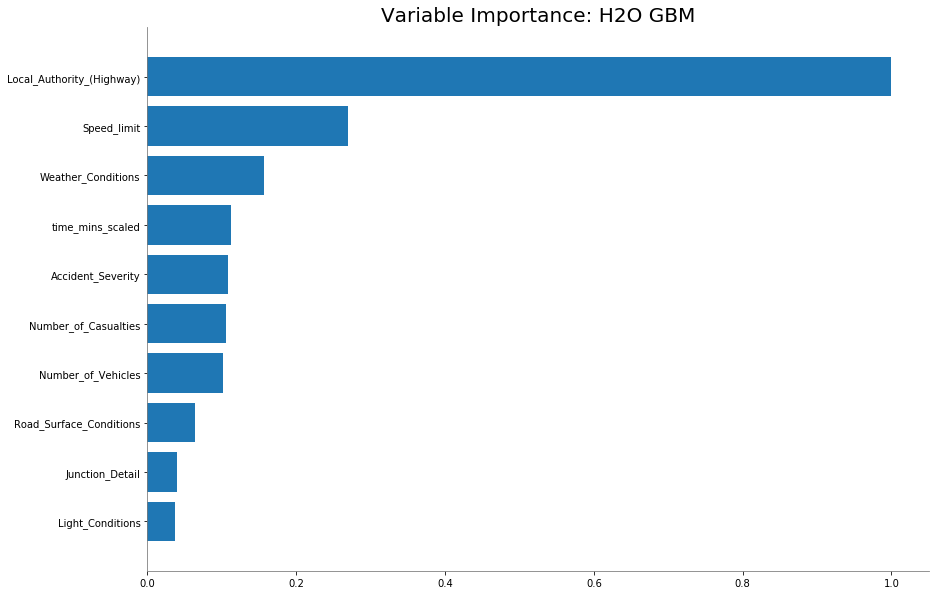

In [197]:
gbm_baseline.varimp_plot()

In [198]:
from h2o.estimators.random_forest import H2ORandomForestEstimator

In [226]:
rf_v1 = H2ORandomForestEstimator(
    model_id="rf_covType_v1",
    ntrees=100,
    stopping_rounds=2,
    score_each_iteration=True,
    seed=1234,balance_classes = True)


In [227]:
rf_v1.train(x=cols, y=y, training_frame=train,
                   validation_frame=valid)

drf Model Build progress: |███████████████████████████████████████████████| 100%


In [228]:
y_pred = rf_v1.predict(test)

drf prediction progress: |████████████████████████████████████████████████| 100%


In [229]:
from sklearn.metrics import accuracy_score, confusion_matrix
conf_mat = confusion_matrix(y_true=test["Did_Police_Officer_Attend_Scene_of_Accident"].as_data_frame().values, y_pred=y_pred["predict"].as_data_frame().values)

In [230]:
from sklearn.metrics import precision_score, recall_score, precision_recall_curve,f1_score, fbeta_score,classification_report
print(classification_report(y_true=test["Did_Police_Officer_Attend_Scene_of_Accident"].as_data_frame().values, y_pred=y_pred["predict"].as_data_frame().values))

              precision    recall  f1-score   support

           1       0.90      0.70      0.79     18034
           2       0.31      0.63      0.42      3939

    accuracy                           0.69     21973
   macro avg       0.60      0.66      0.60     21973
weighted avg       0.79      0.69      0.72     21973



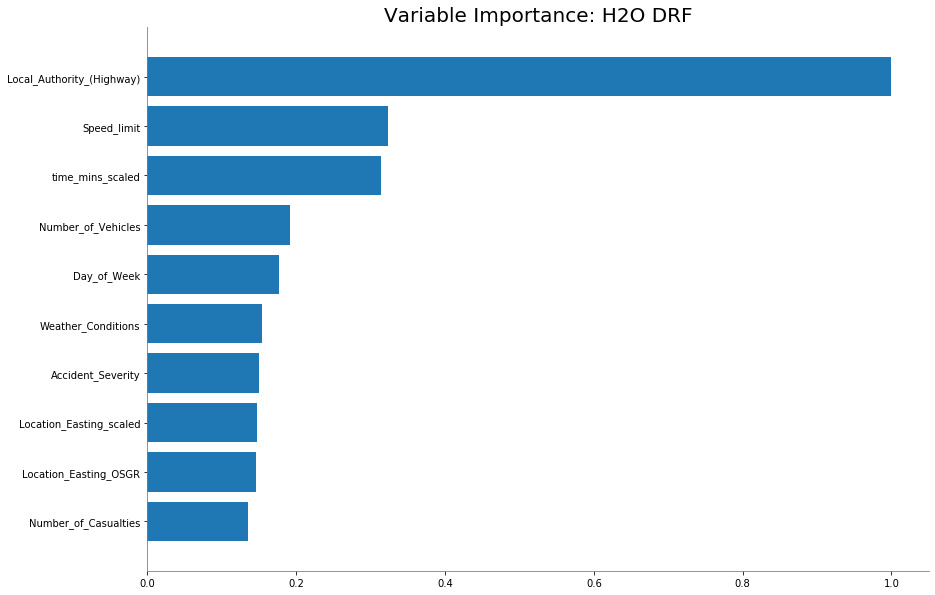

In [231]:
rf_v1.varimp_plot()

In [239]:

aml = H2OAutoML(max_models=20, seed=1, balance_classes = True)
aml.train(x=cols, y=y, training_frame=train)

AutoML progress: |████████████████████████████████████████████████████████| 100%


In [206]:
aml.leaderboard

model_id,auc,logloss,mean_per_class_error,rmse,mse
StackedEnsemble_AllModels_AutoML_20191114_113509,0.794892,0.393244,0.28584,0.35156,0.123595
StackedEnsemble_BestOfFamily_AutoML_20191114_113509,0.794221,0.393789,0.290515,0.351757,0.123733
GBM_1_AutoML_20191114_113509,0.786446,0.39154,0.297669,0.351895,0.12383
GBM_3_AutoML_20191114_113509,0.78436,0.394839,0.301306,0.353311,0.124828
GBM_2_AutoML_20191114_113509,0.783899,0.393386,0.303696,0.352639,0.124355
GBM_5_AutoML_20191114_113509,0.781329,0.402646,0.294512,0.356349,0.126985
GLM_grid_1_AutoML_20191114_113509_model_1,0.778606,0.397031,0.29898,0.354395,0.125596
GBM_4_AutoML_20191114_113509,0.778348,0.402682,0.30526,0.356162,0.126851
XGBoost_2_AutoML_20191114_113509,0.777385,0.397007,0.308084,0.354347,0.125562
XGBoost_1_AutoML_20191114_113509,0.774794,0.399505,0.304478,0.355543,0.126411


In [207]:
y_aml_test = aml.leader.predict(test)

stackedensemble prediction progress: |████████████████████████████████████| 100%


In [208]:
print( classification_report(y_true=test["Did_Police_Officer_Attend_Scene_of_Accident"].as_data_frame().values, y_pred=y_aml_test["predict"].as_data_frame().values))

              precision    recall  f1-score   support

           1       0.91      0.77      0.83     18034
           2       0.38      0.66      0.48      3939

    accuracy                           0.75     21973
   macro avg       0.65      0.71      0.66     21973
weighted avg       0.82      0.75      0.77     21973



In [210]:
aml.leader.coef

Model Details
H2OStackedEnsembleEstimator :  Stacked Ensemble
Model Key:  StackedEnsemble_AllModels_AutoML_20191114_113509

No model summary for this model

ModelMetricsBinomialGLM: stackedensemble
** Reported on train data. **

MSE: 0.10386467812978381
RMSE: 0.32228043398534734
LogLoss: 0.33585325213856687
Null degrees of freedom: 102526
Residual degrees of freedom: 102515
Null deviance: 97469.57354961436
Residual deviance: 68868.0527640217
AIC: 68892.0527640217
AUC: 0.8825592470486826
pr_auc: 0.6219831475917141
Gini: 0.7651184940973652

Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.22632936668377537: 


,,1,2,Error,Rate
0,1,71001.0,12803.0,0.1528,(12803.0/83804.0)
1,2,5203.0,13520.0,0.2779,(5203.0/18723.0)
2,Total,76204.0,26323.0,0.1756,(18006.0/102527.0)



Maximum Metrics: Maximum metrics at their respective thresholds


,metric,threshold,value,idx
0,max f1,0.226329,0.600275,251.0
1,max f2,0.141924,0.719824,308.0
2,max f0point5,0.364650,0.584755,181.0
3,max accuracy,0.399722,0.852234,166.0
4,max precision,0.975346,1.000000,0.0
5,max recall,0.053781,1.000000,387.0
6,max specificity,0.975346,1.000000,0.0
7,max absolute_mcc,0.201541,0.503593,266.0
8,max min_per_class_accuracy,0.189078,0.798434,274.0
9,max mean_per_class_accuracy,0.168731,0.803856,288.0



Gains/Lift Table: Avg response rate: 18.26 %, avg score: 18.51 %


,,group,cumulative_data_fraction,lower_threshold,lift,cumulative_lift,response_rate,score,cumulative_response_rate,cumulative_score,capture_rate,cumulative_capture_rate,gain,cumulative_gain
0,,1,0.010007,0.819090,5.075700,5.075700,0.926901,0.895264,0.926901,0.895264,0.050793,0.050793,407.570028,407.570028
1,,2,0.020004,0.729300,4.594491,4.835213,0.839024,0.769838,0.882984,0.832582,0.045933,0.096726,359.449093,383.521291
2,,3,0.030002,0.669895,4.108330,4.592997,0.750244,0.697422,0.838752,0.787543,0.041072,0.137798,310.832968,359.299727
3,,4,0.040009,0.619340,3.848139,4.406692,0.702729,0.643545,0.804729,0.751526,0.038509,0.176307,284.813869,340.669183
4,,5,0.050006,0.580196,3.536690,4.232759,0.645854,0.599895,0.772967,0.721212,0.035358,0.211665,253.668953,323.275925
5,,6,0.100003,0.437034,3.093733,3.663301,0.564963,0.502229,0.668975,0.611731,0.154676,0.366341,209.373256,266.330145
6,,7,0.150000,0.342693,2.665353,3.330674,0.486734,0.387005,0.608232,0.536827,0.133259,0.499599,166.535316,233.067365
7,,8,0.200006,0.278283,2.268580,3.065124,0.414277,0.308650,0.559739,0.479777,0.113443,0.613043,126.857952,206.512422
8,,9,0.299999,0.194866,1.738088,2.622808,0.317401,0.232860,0.478965,0.397477,0.173797,0.786840,73.808801,162.280758
9,,10,0.400002,0.145032,1.039867,2.227063,0.189896,0.168180,0.406696,0.340151,0.103990,0.890829,3.986703,122.706279




ModelMetricsBinomialGLM: stackedensemble
** Reported on cross-validation data. **

MSE: 0.12359455169794854
RMSE: 0.3515601679626811
LogLoss: 0.3932443779348592
Null degrees of freedom: 102526
Residual degrees of freedom: 102515
Null deviance: 97473.09384412557
Residual deviance: 80636.33267305463
AIC: 80660.33267305463
AUC: 0.7948915988607544
pr_auc: 0.4696679980466609
Gini: 0.5897831977215089

Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.18344988719872846: 


,,1,2,Error,Rate
0,1,63852.0,19952.0,0.2381,(19952.0/83804.0)
1,2,6246.0,12477.0,0.3336,(6246.0/18723.0)
2,Total,70098.0,32429.0,0.2555,(26198.0/102527.0)



Maximum Metrics: Maximum metrics at their respective thresholds


,metric,threshold,value,idx
0,max f1,0.183450,0.487840,271.0
1,max f2,0.107216,0.628936,330.0
2,max f0point5,0.370731,0.470495,175.0
3,max accuracy,0.576368,0.829362,98.0
4,max precision,0.976976,1.000000,0.0
5,max recall,0.044792,1.000000,398.0
6,max specificity,0.976976,1.000000,0.0
7,max absolute_mcc,0.183450,0.355852,271.0
8,max min_per_class_accuracy,0.161760,0.717673,286.0
9,max mean_per_class_accuracy,0.140451,0.721222,302.0



Gains/Lift Table: Avg response rate: 18.26 %, avg score: 18.26 %


,,group,cumulative_data_fraction,lower_threshold,lift,cumulative_lift,response_rate,score,cumulative_response_rate,cumulative_score,capture_rate,cumulative_capture_rate,gain,cumulative_gain
0,,1,0.010007,0.801430,4.419222,4.419222,0.807018,0.883032,0.807018,0.883032,0.044224,0.044224,341.922169,341.922169
1,,2,0.020004,0.711439,3.472580,3.946132,0.634146,0.750961,0.720624,0.817028,0.034717,0.078940,247.258035,294.613180
2,,3,0.030002,0.652230,3.285595,3.726025,0.600000,0.679978,0.680429,0.771360,0.032847,0.111788,228.559526,272.602453
3,,4,0.040009,0.605674,2.930136,3.526955,0.535088,0.628342,0.644076,0.735588,0.029322,0.141110,193.013612,252.695542
4,,5,0.050006,0.566770,2.831489,3.387916,0.517073,0.585951,0.618685,0.705672,0.028307,0.169417,183.148860,238.791631
5,,6,0.100003,0.426413,2.484814,2.936409,0.453765,0.490440,0.536233,0.598067,0.124232,0.293650,148.481420,193.640930
6,,7,0.150000,0.332765,2.163263,2.678710,0.395045,0.376516,0.489174,0.524221,0.108156,0.401805,116.326258,167.871048
7,,8,0.200006,0.270637,1.829603,2.466413,0.334114,0.300111,0.450405,0.468188,0.091492,0.493297,82.960298,146.641290
8,,9,0.299999,0.191693,1.508408,2.147099,0.275458,0.227400,0.392093,0.387931,0.150831,0.644128,50.840828,114.709879
9,,10,0.400002,0.144910,1.169650,1.902731,0.213596,0.166379,0.347468,0.332542,0.116968,0.761096,16.965012,90.273067


<bound method ModelBase.coef of >

In [164]:
# Get model ids for all models in the AutoML Leaderboard
model_ids = list(aml.leaderboard['model_id'].as_data_frame().iloc[:,0])
# Get the "All Models" Stacked Ensemble model
se = h2o.get_model([mid for mid in model_ids if "StackedEnsemble_AllModels" in mid][0])
# Get the Stacked Ensemble metalearner model
metalearner = h2o.get_model(se.metalearner()['name'])

In [165]:
metalearner.coef_norm()

{'Intercept': -1.7813973400033343,
 'GBM_1_AutoML_20191114_113509': 0.23060522114435952,
 'GBM_3_AutoML_20191114_113509': 0.08234105261886174,
 'GBM_2_AutoML_20191114_113509': 0.11232928766159635,
 'GBM_5_AutoML_20191114_113509': 0.04300539875454232,
 'GLM_grid_1_AutoML_20191114_113509_model_1': 0.28611998993853666,
 'GBM_4_AutoML_20191114_113509': 0.0,
 'XGBoost_2_AutoML_20191114_113509': 0.051571212600846114,
 'XGBoost_1_AutoML_20191114_113509': 0.09521615175555533,
 'DeepLearning_1_AutoML_20191114_113509': 0.08983885848431679,
 'XGBoost_grid_1_AutoML_20191114_113509_model_1': 0.0,
 'XGBoost_3_AutoML_20191114_113509': 0.0,
 'XGBoost_grid_1_AutoML_20191114_113509_model_3': 0.0,
 'XGBoost_grid_1_AutoML_20191114_113509_model_4': 0.10923159140954274,
 'XGBoost_grid_1_AutoML_20191114_113509_model_2': 0.0,
 'GBM_grid_1_AutoML_20191114_113509_model_1': 0.0,
 'DRF_1_AutoML_20191114_113509': 0.0038476016737585576,
 'XRT_1_AutoML_20191114_113509': 0.0,
 'DeepLearning_grid_1_AutoML_20191114_113

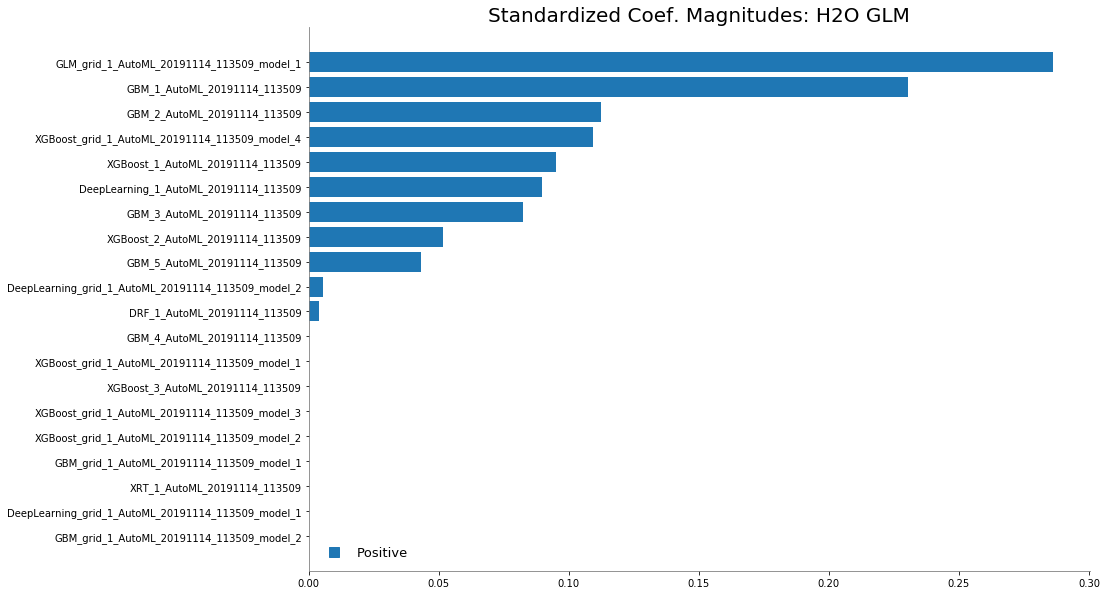

In [166]:
%matplotlib inline
metalearner.std_coef_plot()

In [238]:
param = {
      "ntrees" : 100
    , "max_depth" : 10
    , "learn_rate" : 0.02
    , "sample_rate" : 0.7
    , "col_sample_rate_per_tree" : 0.9
    , "min_rows" : 5
    , "seed": 4241
    , "score_tree_interval": 100
    
}
from h2o.estimators import H2OXGBoostEstimator
model = H2OXGBoostEstimator(**param)

H2OValueError: Unknown parameter balance_classes = True

In [212]:
model.train(x=cols, y=y, training_frame=train,validation_frame=valid)

xgboost Model Build progress: |███████████████████████████████████████████| 100%


In [213]:
y_xgb_test = model.predict(test)

xgboost prediction progress: |████████████████████████████████████████████| 100%


In [214]:
print( classification_report(y_true=test["Did_Police_Officer_Attend_Scene_of_Accident"].as_data_frame().values, y_pred=y_xgb_test["predict"].as_data_frame().values))

              precision    recall  f1-score   support

           1       0.90      0.72      0.80     18034
           2       0.33      0.63      0.43      3939

    accuracy                           0.71     21973
   macro avg       0.61      0.67      0.62     21973
weighted avg       0.80      0.71      0.74     21973



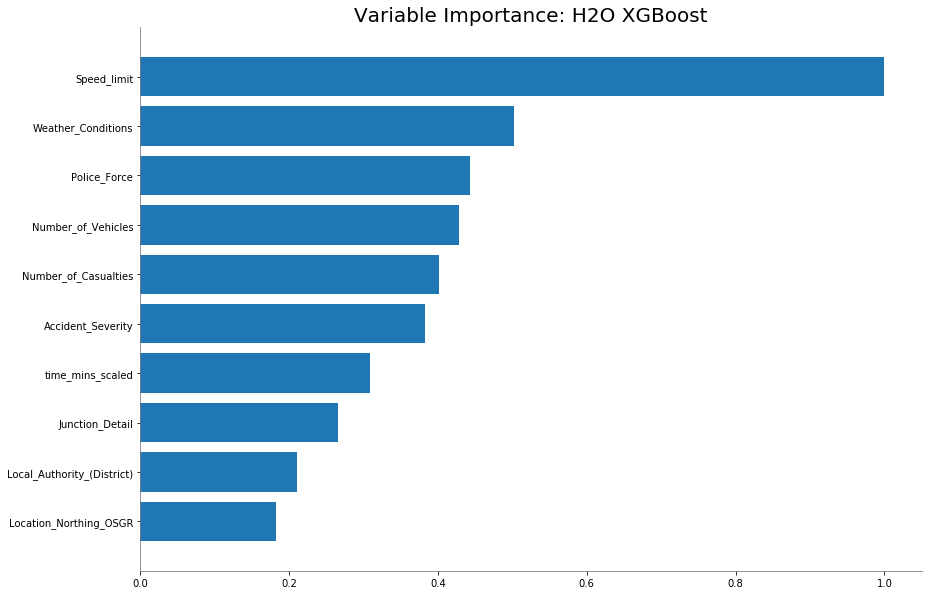

In [218]:
model.varimp_plot()

In [217]:
model.F1

Model Details
H2OXGBoostEstimator :  XGBoost
Model Key:  XGBoost_model_python_1573665384110_27167


Model Summary: 


,,number_of_trees
0,,100.0




ModelMetricsBinomial: xgboost
** Reported on train data. **

MSE: 0.1308599046319276
RMSE: 0.3617456352631329
LogLoss: 0.4200979975176377
Mean Per-Class Error: 0.2972380668874044
AUC: 0.7741083981769667
pr_auc: 0.4350619236191693
Gini: 0.5482167963539335

Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.25519815644718463: 


,,1,2,Error,Rate
0,1,60523.0,23281.0,0.2778,(23281.0/83804.0)
1,2,6169.0,12554.0,0.3295,(6169.0/18723.0)
2,Total,66692.0,35835.0,0.2872,(29450.0/102527.0)



Maximum Metrics: Maximum metrics at their respective thresholds


,metric,threshold,value,idx
0,max f1,0.255198,0.460207,212.0
1,max f2,0.189453,0.620035,279.0
2,max f0point5,0.342749,0.421703,135.0
3,max accuracy,0.407343,0.826797,87.0
4,max precision,0.862436,1.000000,0.0
5,max recall,0.079161,1.000000,392.0
6,max specificity,0.862436,1.000000,0.0
7,max absolute_mcc,0.249421,0.318774,217.0
8,max min_per_class_accuracy,0.247610,0.699194,219.0
9,max mean_per_class_accuracy,0.230316,0.702762,236.0



Gains/Lift Table: Avg response rate: 18.26 %, avg score: 22.58 %


,,group,cumulative_data_fraction,lower_threshold,lift,cumulative_lift,response_rate,score,cumulative_response_rate,cumulative_score,capture_rate,cumulative_capture_rate,gain,cumulative_gain
0,,1,0.010007,0.515354,4.579338,4.579338,0.836257,0.677469,0.836257,0.677469,0.045826,0.045826,357.933842,357.933842
1,,2,0.020024,0.409410,3.417830,3.998301,0.624148,0.442792,0.730151,0.560073,0.034236,0.080062,241.782954,299.830110
2,,3,0.030002,0.398705,2.612203,3.537320,0.477028,0.403636,0.645969,0.508046,0.026064,0.106126,161.220346,253.731999
3,,4,0.040077,0.393610,2.443787,3.262407,0.446273,0.395621,0.595765,0.479782,0.024622,0.130748,144.378737,226.240658
4,,5,0.050006,0.389618,2.420625,3.095265,0.442043,0.391553,0.565243,0.462264,0.024035,0.154783,142.062519,209.526528
5,,6,0.100218,0.352884,2.171037,2.632207,0.396465,0.373181,0.480681,0.417632,0.109010,0.263793,117.103727,163.220681
6,,7,0.150000,0.337961,1.932261,2.399908,0.352861,0.345020,0.438260,0.393533,0.096192,0.359985,93.226132,139.990810
7,,8,0.200006,0.316594,1.781540,2.245301,0.325336,0.328295,0.410026,0.377222,0.089088,0.449073,78.153985,124.530096
8,,9,0.299999,0.271881,1.529774,2.006807,0.279360,0.292116,0.366474,0.348855,0.152967,0.602040,52.977384,100.680743
9,,10,0.400002,0.239922,1.267922,1.822082,0.231542,0.254914,0.332740,0.325369,0.126796,0.728836,26.792209,82.208159




ModelMetricsBinomial: xgboost
** Reported on validation data. **

MSE: 0.13566581648099874
RMSE: 0.3683284084631523
LogLoss: 0.4326683554482371
Mean Per-Class Error: 0.31814289217588376
AUC: 0.7463664273798475
pr_auc: 0.39883488430794994
Gini: 0.49273285475969497

Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.25939653369418364: 


,,1,2,Error,Rate
0,1,12954.0,4815.0,0.271,(4815.0/17769.0)
1,2,1528.0,2525.0,0.377,(1528.0/4053.0)
2,Total,14482.0,7340.0,0.2907,(6343.0/21822.0)



Maximum Metrics: Maximum metrics at their respective thresholds


,metric,threshold,value,idx
0,max f1,0.259397,0.443255,205.0
1,max f2,0.183229,0.598565,286.0
2,max f0point5,0.329190,0.402726,143.0
3,max accuracy,0.410517,0.819907,77.0
4,max precision,0.848901,1.000000,0.0
5,max recall,0.077534,1.000000,393.0
6,max specificity,0.848901,1.000000,0.0
7,max absolute_mcc,0.259397,0.289749,205.0
8,max min_per_class_accuracy,0.245281,0.677523,220.0
9,max mean_per_class_accuracy,0.237121,0.681857,228.0



Gains/Lift Table: Avg response rate: 18.57 %, avg score: 22.66 %


,,group,cumulative_data_fraction,lower_threshold,lift,cumulative_lift,response_rate,score,cumulative_response_rate,cumulative_score,capture_rate,cumulative_capture_rate,gain,cumulative_gain
0,,1,0.010036,0.515757,3.958218,3.958218,0.735160,0.672256,0.735160,0.672256,0.039724,0.039724,295.821800,295.821800
1,,2,0.020026,0.409706,2.864966,3.412843,0.532110,0.443214,0.633867,0.557997,0.028621,0.068344,186.496581,241.284276
2,,3,0.030016,0.398403,2.543892,3.123635,0.472477,0.403464,0.580153,0.506565,0.025413,0.093758,154.389205,212.363474
3,,4,0.040005,0.394333,2.371006,2.935693,0.440367,0.396042,0.545246,0.478966,0.023686,0.117444,137.100619,193.569313
4,,5,0.050041,0.389916,2.458520,2.839996,0.456621,0.392096,0.527473,0.461544,0.024673,0.142117,145.852049,183.999642
5,,6,0.100128,0.353975,2.044306,2.441969,0.379689,0.374952,0.453547,0.418228,0.102393,0.244510,104.430590,144.196908
6,,7,0.150032,0.338096,1.854050,2.246415,0.344353,0.345581,0.417227,0.394064,0.092524,0.337034,85.404955,124.641490
7,,8,0.200027,0.316717,1.653248,2.098157,0.307058,0.328757,0.389691,0.377741,0.082655,0.419689,65.324799,109.815715
8,,9,0.300018,0.272682,1.561949,1.919448,0.290101,0.292655,0.356499,0.349383,0.156181,0.575870,56.194922,91.944847
9,,10,0.400009,0.241052,1.179481,1.734478,0.219065,0.255457,0.322145,0.325904,0.117937,0.693807,17.948140,73.447790




Scoring History: 


,,timestamp,duration,number_of_trees,training_rmse,training_logloss,training_auc,training_pr_auc,training_lift,training_classification_error,validation_rmse,validation_logloss,validation_auc,validation_pr_auc,validation_lift,validation_classification_error
0,,2019-11-14 16:06:50,0.051 sec,0.0,0.500000,0.693147,0.500000,0.000000,1.000000,0.817385,0.500000,0.693147,0.500000,0.000000,1.000000,0.81427
1,,2019-11-14 16:06:53,3.473 sec,100.0,0.361746,0.420098,0.774108,0.435062,4.579338,0.287241,0.368328,0.432668,0.746366,0.398835,3.958218,0.29067



Variable Importances: 


,variable,relative_importance,scaled_importance,percentage
0,Speed_limit,41233.433594,1.000000,0.184628
1,Weather_Conditions,20721.427734,0.502539,0.092783
2,Police_Force,18246.199219,0.442510,0.081700
3,Number_of_Vehicles,17661.884766,0.428339,0.079083
4,Number_of_Casualties,16560.285156,0.401623,0.074151
5,Accident_Severity,15790.104492,0.382944,0.070702
6,time_mins_scaled,12727.809570,0.308677,0.056990
7,Junction_Detail,10930.958008,0.265099,0.048945
8,Local_Authority_(District),8682.553711,0.210571,0.038877
9,Location_Northing_OSGR,7506.125977,0.182040,0.033610



See the whole table with table.as_data_frame()


<bound method H2OBinomialModel.F1 of >

In [220]:
cols

['Location_Easting_OSGR',
 'Location_Northing_OSGR',
 'Police_Force',
 'Accident_Severity',
 'Number_of_Vehicles',
 'Number_of_Casualties',
 'Day_of_Week',
 'Local_Authority_(District)',
 'Local_Authority_(Highway)',
 '1st_Road_Class',
 '1st_Road_Number',
 'Road_Type',
 'Speed_limit',
 'Junction_Detail',
 '2nd_Road_Number',
 'Pedestrian_Crossing-Human_Control',
 'Pedestrian_Crossing-Physical_Facilities',
 'Light_Conditions',
 'Weather_Conditions',
 'Road_Surface_Conditions',
 'Special_Conditions_at_Site',
 'Carriageway_Hazards',
 'Urban_or_Rural_Area',
 'time_mins_scaled',
 'Location_Easting_scaled',
 'Location_Northing_scaled']

In [249]:
nfolds = 5

# There are a few ways to assemble a list of models to stack together:
# 1. Train individual models and put them in a list
# 2. Train a grid of models
# 3. Train several grids of models
# Note: All base models must have the same cross-validation folds and
# the cross-validated predicted values must be kept.


# 1. Generate a 2-model ensemble (GBM + RF)

# Train and cross-validate a GBM
my_gbm = H2OGradientBoostingEstimator(distribution="bernoulli",
                                      ntrees=10,
                                      max_depth=3,
                                      min_rows=2,
                                      learn_rate=0.2,
                                      nfolds=nfolds,
                                      fold_assignment="Modulo",
                                      keep_cross_validation_predictions=True,
                                      seed=1)
my_gbm.train(x=cols, y=y, training_frame=train)


# Train and cross-validate a RF
my_rf = H2ORandomForestEstimator(ntrees=50,
                                 nfolds=nfolds,
                                 fold_assignment="Modulo",
                                 keep_cross_validation_predictions=True,
                                 seed=1)
my_rf.train(x=cols, y=y, training_frame=train)


# Train a stacked ensemble using the GBM and GLM above
ensemble = H2OStackedEnsembleEstimator(model_id="my_ensemble_binomial2",
                                       base_models=[my_gbm, my_rf])
ensemble.train(x=cols, y=y, training_frame=train)

gbm Model Build progress: |███████████████████████████████████████████████| 100%
drf Model Build progress: |███████████████████████████████████████████████| 100%
stackedensemble Model Build progress: |███████████████████████████████████| 100%


In [250]:
y_ens_predict=ensemble.predict(test)

stackedensemble prediction progress: |████████████████████████████████████| 100%


In [251]:
print( classification_report(y_true=test["Did_Police_Officer_Attend_Scene_of_Accident"].as_data_frame().values, y_pred=y_ens_predict["predict"].as_data_frame().values))

              precision    recall  f1-score   support

           1       0.90      0.70      0.79     18034
           2       0.32      0.64      0.43      3939

    accuracy                           0.69     21973
   macro avg       0.61      0.67      0.61     21973
weighted avg       0.80      0.69      0.72     21973



In [259]:
# Specify GBM hyperparameters for the grid
hyper_params = {"learn_rate": [0.0001, 0.01],
                "max_depth": [3, 4, 5, 6, 9],
                "sample_rate": [0.7, 0.8, 0.9, 1.0],
                "col_sample_rate": [0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8]}
search_criteria = {"strategy": "RandomDiscrete", "max_models": 3, "seed": 1}

# Train the grid
grid = H2OGridSearch(model=H2OGradientBoostingEstimator(ntrees=10,
                                                        seed=1,
                                                        nfolds=nfolds,
                                                        fold_assignment="Modulo",
                                                        keep_cross_validation_predictions=True),
                     hyper_params=hyper_params,
                     search_criteria=search_criteria,
                     grid_id="gbm_grid_binomial2")
grid.train(x=cols, y=y, training_frame=train)

# Train a stacked ensemble using the GBM grid
ensemble = H2OStackedEnsembleEstimator(model_id="my_ensemble_gbm_grid_binomial2",
                                       base_models=grid.model_ids)
ensemble.train(x=cols, y=y, training_frame=train)

gbm Grid Build progress: |████████████████████████████████████████████████| 100%
stackedensemble Model Build progress: |███████████████████████████████████| 100%


In [260]:
y_ens_predict2=ensemble.predict(test)

stackedensemble prediction progress: |████████████████████████████████████| 100%


In [261]:
print( classification_report(y_true=test["Did_Police_Officer_Attend_Scene_of_Accident"].as_data_frame().values, y_pred=y_ens_predict2["predict"].as_data_frame().values))

              precision    recall  f1-score   support

           1       0.90      0.63      0.74     18034
           2       0.29      0.68      0.40      3939

    accuracy                           0.64     21973
   macro avg       0.59      0.66      0.57     21973
weighted avg       0.79      0.64      0.68     21973



In [262]:
ensemble.model_performance(test)



ModelMetricsBinomialGLM: stackedensemble
** Reported on test data. **

MSE: 0.13431882640460568
RMSE: 0.3664953293080359
LogLoss: 0.42868035617047323
Null degrees of freedom: 21972
Residual degrees of freedom: 21970
Null deviance: 20668.48985978331
Residual deviance: 18838.786932267616
AIC: 18844.786932267616
AUC: 0.7122668605741832
pr_auc: 0.35245228768870734
Gini: 0.4245337211483664

Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.1641174576804823: 


,,1,2,Error,Rate
0,1,11240.0,6794.0,0.3767,(6794.0/18034.0)
1,2,1212.0,2727.0,0.3077,(1212.0/3939.0)
2,Total,12452.0,9521.0,0.3644,(8006.0/21973.0)



Maximum Metrics: Maximum metrics at their respective thresholds


,metric,threshold,value,idx
0,max f1,0.164117,0.405201,255.0
1,max f2,0.121349,0.566714,309.0
2,max f0point5,0.287314,0.357770,150.0
3,max accuracy,0.595437,0.825650,60.0
4,max precision,0.983037,0.880000,2.0
5,max recall,0.052551,1.000000,397.0
6,max specificity,0.986895,0.999945,0.0
7,max absolute_mcc,0.164117,0.244276,255.0
8,max min_per_class_accuracy,0.177724,0.652958,240.0
9,max mean_per_class_accuracy,0.161312,0.657972,258.0



Gains/Lift Table: Avg response rate: 17.93 %, avg score: 18.24 %


,,group,cumulative_data_fraction,lower_threshold,lift,cumulative_lift,response_rate,score,cumulative_response_rate,cumulative_score,capture_rate,cumulative_capture_rate,gain,cumulative_gain
0,,1,0.010012,0.643612,4.107672,4.107672,0.736364,0.884229,0.736364,0.884229,0.041127,0.041127,310.767154,310.767154
1,,2,0.029354,0.343415,2.296955,2.914564,0.411765,0.377269,0.522481,0.550186,0.044428,0.085555,129.695503,191.456376
2,,3,0.030446,0.340529,2.091870,2.885050,0.375000,0.341590,0.517190,0.542702,0.002285,0.087840,109.186976,188.505008
3,,4,0.042461,0.333810,2.218650,2.696487,0.397727,0.335591,0.483387,0.484098,0.026657,0.114496,121.864975,169.648664
4,,5,0.050471,0.328405,1.965090,2.580413,0.352273,0.329843,0.462579,0.459618,0.015740,0.130236,96.508978,158.041284
5,,6,0.100396,0.315261,1.922156,2.253075,0.344576,0.322303,0.403898,0.391334,0.095963,0.226200,92.215563,125.307460
6,,7,0.150457,0.299798,1.587285,2.031548,0.284545,0.307154,0.364186,0.363325,0.079462,0.305661,58.728542,103.154765
7,,8,0.201793,0.284833,1.671518,1.939957,0.299645,0.291840,0.347767,0.345139,0.085809,0.391470,67.151768,93.995680
8,,9,0.300187,0.247260,1.450053,1.779379,0.259944,0.268328,0.318981,0.319962,0.142676,0.534146,45.005342,77.937901
9,,10,0.400036,0.177500,1.182278,1.630342,0.211942,0.208364,0.292264,0.292107,0.118050,0.652196,18.227826,63.034158


In [263]:
ensemble.auc

Model Details
H2OStackedEnsembleEstimator :  Stacked Ensemble
Model Key:  my_ensemble_gbm_grid_binomial2

No model summary for this model

ModelMetricsBinomialGLM: stackedensemble
** Reported on train data. **

MSE: 0.1346490596274505
RMSE: 0.3669455812889024
LogLoss: 0.4273698477504106
Null degrees of freedom: 102526
Residual degrees of freedom: 102524
Null deviance: 97469.57354961436
Residual deviance: 87633.89676061276
AIC: 87639.89676061276
AUC: 0.7249563104024935
pr_auc: 0.37483828326695
Gini: 0.44991262080498706

Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.16432817294525484: 


,,1,2,Error,Rate
0,1,52488.0,31316.0,0.3737,(31316.0/83804.0)
1,2,5536.0,13187.0,0.2957,(5536.0/18723.0)
2,Total,58024.0,44503.0,0.3594,(36852.0/102527.0)



Maximum Metrics: Maximum metrics at their respective thresholds


,metric,threshold,value,idx
0,max f1,0.164328,0.417139,254.0
1,max f2,0.130357,0.585045,297.0
2,max f0point5,0.288771,0.376799,153.0
3,max accuracy,0.726151,0.823266,52.0
4,max precision,0.989201,1.000000,0.0
5,max recall,0.053634,1.000000,394.0
6,max specificity,0.989201,1.000000,0.0
7,max absolute_mcc,0.164328,0.257737,254.0
8,max min_per_class_accuracy,0.177866,0.657749,241.0
9,max mean_per_class_accuracy,0.154147,0.665876,265.0



Gains/Lift Table: Avg response rate: 18.26 %, avg score: 18.30 %


,,group,cumulative_data_fraction,lower_threshold,lift,cumulative_lift,response_rate,score,cumulative_response_rate,cumulative_score,capture_rate,cumulative_capture_rate,gain,cumulative_gain
0,,1,0.010007,0.701163,4.333826,4.333826,0.791423,0.903993,0.791423,0.903993,0.043369,0.043369,333.382610,333.382610
1,,2,0.029446,0.343415,2.316237,3.001910,0.422980,0.390009,0.548195,0.564685,0.045025,0.088394,131.623750,200.191021
2,,3,0.030060,0.341952,2.433774,2.990297,0.444444,0.343026,0.546074,0.560154,0.001495,0.089889,143.377426,199.029679
3,,4,0.041609,0.333810,2.132122,2.752116,0.389358,0.335981,0.502579,0.497937,0.024622,0.114512,113.212192,175.211605
4,,5,0.051167,0.328305,2.184809,2.646138,0.398980,0.329484,0.483225,0.466468,0.020883,0.135395,118.480909,164.613800
5,,6,0.100003,0.314919,1.963133,2.312596,0.358498,0.322029,0.422315,0.395932,0.095871,0.231266,96.313278,131.259590
6,,7,0.150234,0.299798,1.816115,2.146597,0.331650,0.307270,0.392002,0.366288,0.091225,0.322491,81.611544,114.659743
7,,8,0.201088,0.284833,1.634186,2.017009,0.298427,0.291658,0.368337,0.347414,0.083106,0.405597,63.418560,101.700946
8,,9,0.299999,0.247397,1.332144,1.791207,0.243270,0.269360,0.327102,0.321679,0.131763,0.537360,33.214402,79.120738
9,,10,0.400060,0.177501,1.229816,1.650795,0.224583,0.209665,0.301460,0.293663,0.123057,0.660418,22.981634,65.079460


<bound method ModelBase.auc of >

In [ ]:
from h2o.estimators.deeplearning import H2ODeepLearningEstimator
dl = H2ODeepLearningEstimator(distribution='auto',
                              model_id='dl',
                              epochs=20,
                              activation='rectifier_with_dropout',
                              hidden_dropout_ratios=[0,0],
                              rate=0.001,
                              loss = "cross_entropy",
                              balance_classes = True,
                              hidden = [400,400],
                              seed=1234)
dl.train(x=cols, y=y, training_frame=train, validation_frame=valid)


In [279]:
y_dl_predict =dl.predict(test)

deeplearning prediction progress: |███████████████████████████████████████| 100%


In [280]:
print( classification_report(y_true=test["Did_Police_Officer_Attend_Scene_of_Accident"].as_data_frame().values, y_pred=y_dl_predict["predict"].as_data_frame().values))

              precision    recall  f1-score   support

           1       0.89      0.73      0.80     18034
           2       0.32      0.57      0.41      3939

    accuracy                           0.71     21973
   macro avg       0.60      0.65      0.61     21973
weighted avg       0.79      0.71      0.73     21973



TypeError: 'NoneType' object is not subscriptable